# Make a DEM Cube

Get a DEM temperature distribution over the solar disk

In [1]:
import sys
import glob

import numpy as np
import astropy.units as u
import astropy.time
import astropy.wcs
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
from sunpy.map import Map, make_fitswcs_header
from sunpy.net import Fido, attrs as a
from sunpy.net.attr import and_,or_
from sunpy.time import TimeRange
from sunpy.coordinates import Helioprojective
from ndcube import NDCube, NDCollection
from astropy.nddata import StdDevUncertainty
from astropy.visualization import (ImageNormalize, LogStretch, SqrtStretch, AsinhStretch,
                                   PowerStretch, quantity_support, AsymmetricPercentileInterval)
from aiapy.calibrate import register, estimate_error, normalize_exposure
from sunkit_dem import Model

sys.path.append('../../scripts/')
from util import CDELT_SPACE
from dem import (get_aia_temperature_response,
                 get_xrt_temperature_response,
                 PlowmanModel)

## Get Data

In [2]:
date = astropy.time.Time('2020-11-09 18:00:00') 
euv_wavelengths = or_(*[a.Wavelength(w) 
                        for w in [94,131,171,193,211,335]*u.angstrom])
q = Fido.search(a.Time(date, date+1*u.h, near=date),
                euv_wavelengths,
                a.Instrument.aia)

In [2]:
#files = Fido.fetch(q, path='../data/{instrument}')
files = sorted(glob.glob('../data/AIA/*.fits'))

For now, I'm grabbing the Be-thin synoptic image from [here](http://solar.physics.montana.edu/HINODE/XRT/SCIA/synop_images/syncmp_FITS/2020/11/). Once the XRT data comes back online in the VSO, we'll just query it from there.

In [3]:
files += ['../data/XRT/comp_XRT20201109_181902.6.fits']

## Build Data Cube

Doing this for AIA only now, will add XRT in soon.

In [4]:
cubes = []
ref_coordinate = SkyCoord(0,0,unit='arcsec', frame=Map(files[0]).coordinate_frame)
for f in files:
    m = Map(f)    
    # Construct new WCS to reproject to. This will resample and derotate each map to the same
    # frame
    new_header = make_fitswcs_header(
        (450,450),  # It doesn't really matter what this is as long as we include the full disk
        ref_coordinate,
        scale=u.Quantity([CDELT_SPACE, CDELT_SPACE]),
        rotation_angle=0*u.deg,
        instrument=m.instrument,
        observatory=m.observatory,
        wavelength=m.wavelength,
        exposure=m.exposure_time,
        projection_code='TAN',
    )
    new_header['BUNIT'] = str(m.unit if m.unit is not None else u.ct)
    if 'EC_FW1_' in m.meta:
        new_header['EC_FW1_'] = m.meta['EC_FW1_']
    if 'EC_FW2_' in m.meta:
        new_header['EC_FW2_'] = m.meta['EC_FW2_']
    with Helioprojective.assume_spherical_screen(m.observer_coordinate, only_off_disk=True):
        _m = m.reproject_to(astropy.wcs.WCS(new_header), algorithm='adaptive')  # switch to adaptive
    n_sample = int(np.round(m.dimensions.x / _m.dimensions.x))
    new_data = _m.data
    new_data[np.isnan(new_data)] = np.nanmin(new_data)
    m = Map(new_data, new_header)
    # REMOVE THIS BLOCK
    #blc = SkyCoord(Tx=-50*u.arcsec,Ty=-550*u.arcsec,frame=m.coordinate_frame)
    #m = m.submap(blc, width=200*u.arcsec, height=200*u.arcsec)
    # REMOVE THIS BLOCK
    # compute uncertainties
    if 'AIA' in m.instrument:
        error = estimate_error(m.quantity/u.pix, m.wavelength, n_sample=n_sample) * u.pix
    else:
        # For XRT, just assume 20% uncertainty
        error = m.quantity*0.2
    error[np.isnan(error)] = 0.0 * error.unit
    error = StdDevUncertainty(error)
    # Build cube
    cube = NDCube(m.quantity, wcs=m.wcs, uncertainty=error, meta=m.meta, )
    cubes.append((str(m.measurement), cube))
map_collection = NDCollection(cubes, aligned_axes=(0,1))

/home/jovyan/users_conda_envs/mocksipipeline/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 10 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/jovyan/users_conda_envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/jovyan/users_conda_envs/mocksipipeline/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 10 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/jovyan/users_conda_envs/mocksipipeline/lib/python3.9/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/jovyan/users_conda_envs/mocksipipeline/lib/python3.9/site-packages/e

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


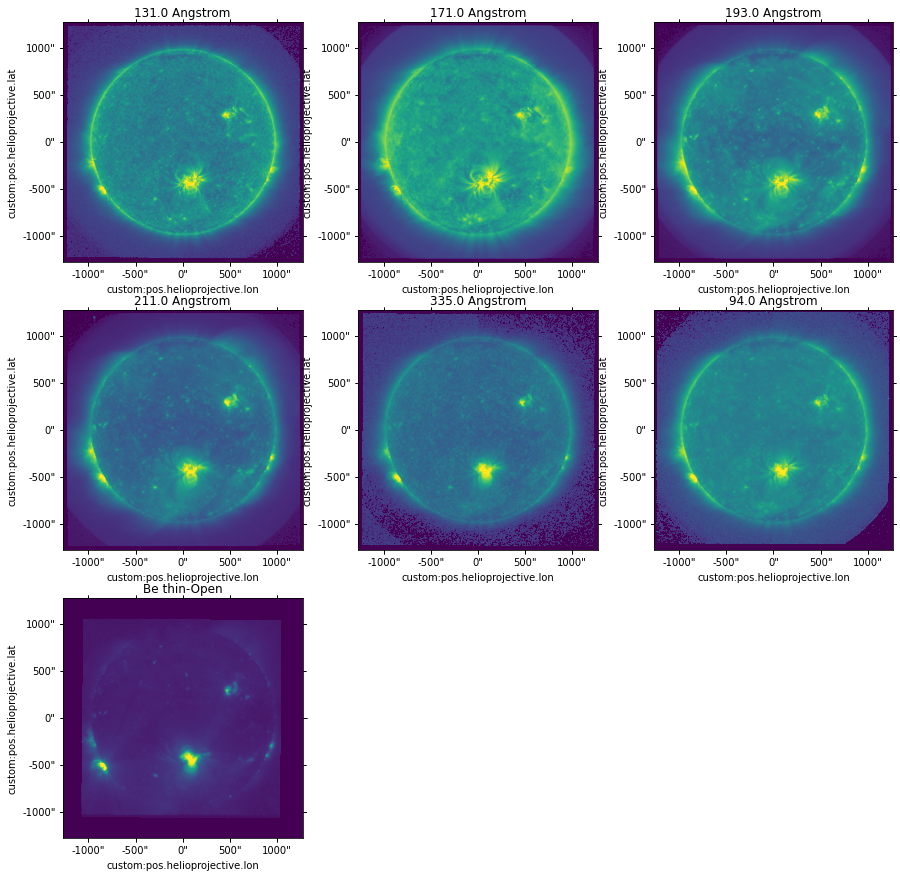

In [5]:
fig = plt.figure(figsize=(15,15))
for i,k in enumerate(map_collection):
    vmin,vmax = AsymmetricPercentileInterval(1,99.9).get_limits(map_collection[k].data)
    vmin = max(vmin,0)
    norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=PowerStretch(0.3))
    ax = fig.add_subplot(3,3,i+1,projection=map_collection[k].wcs)
    map_collection[k].plot(axes=ax,norm=norm)
    ax.set_title(k)

## Response Functions

In [6]:
logt_bin_width = 0.1
logt = np.arange(5.5, 7.6, logt_bin_width)
temperature_bin_edges = 10**logt * u.K
temperature_bin_centers = 10**((logt[1:] + logt[:-1])/2) * u.K

In [7]:
aia_euv_channels = [94, 131, 171, 193, 211, 335] * u.angstrom
aia_responses = get_aia_temperature_response(aia_euv_channels, temperature_bin_centers)
xrt_channels = ['Be_thin']
xrt_responses = get_xrt_temperature_response(xrt_channels, temperature_bin_centers,
                                             correction_factor=2)
all_responses = {**aia_responses, **xrt_responses}

(1e-30, 3e-24)

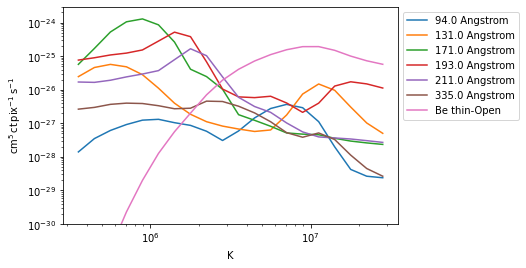

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
with quantity_support():
    for k in all_responses:
        ax.plot(temperature_bin_centers, all_responses[k], label=k)
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(bbox_to_anchor=(1,1))
ax.set_ylim(1e-30, 3e-24)

## Invert

In [9]:
reg_model = Model(
    map_collection,
    {k: all_responses[k] for k in map_collection},
    temperature_bin_edges,
    model='plowman'
)

In [10]:
dem = reg_model.fit(method=None)

/home/jovyan/moxsi-tools/simulation_pipeline/physics/dem_algorithms.py:68: RuntimeWarning: invalid value encountered in true_divide
  s_mat = np.sum(rvec * ((dat0_mat > 1.0e-2)/errors**2), axis=2) / np.sum((rvec/errors)**2, axis=2)
/home/jovyan/moxsi-tools/simulation_pipeline/physics/dem_algorithms.py:68: RuntimeWarning: divide by zero encountered in true_divide
  s_mat = np.sum(rvec * ((dat0_mat > 1.0e-2)/errors**2), axis=2) / np.sum((rvec/errors)**2, axis=2)
/home/jovyan/moxsi-tools/simulation_pipeline/physics/dem_algorithms.py:81: RuntimeWarning: divide by zero encountered in true_divide
  mmat = Rij*np.outer(1.0/err, np.exp(s))


In [11]:
dem['dem']

NDCube
------
Dimensions: [ 20. 450. 450.] pix
Physical Types of Axes: [('phys.temperature',), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat'), ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat')]
Unit: pix / (cm5 K)
Data Type: float64

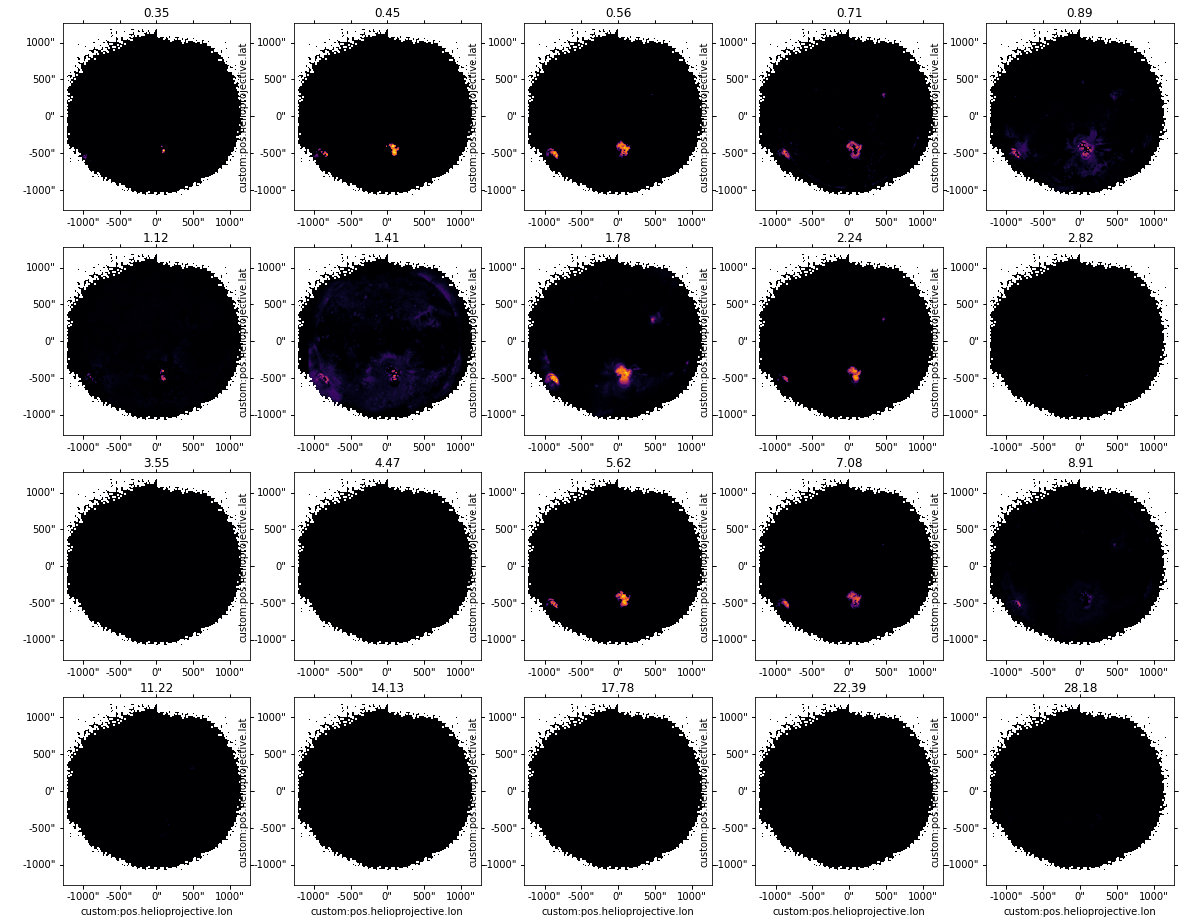

In [12]:
tbin_centers = dem['dem'].axis_world_coords(0)[0]
norm = ImageNormalize(vmin=1e17,vmax=1e21,stretch=LogStretch())
fig = plt.figure(figsize=(20,20))
for i in range(int(dem['dem'].dimensions[0].value)):
    ax = fig.add_subplot(5,5,i+1,projection=dem['dem'][i].wcs)
    dem['dem'][i,...].plot(axes=ax, cmap='inferno', norm=norm)
    ax.set_title(f"{tbin_centers[i].to_value('MK'):0.2f}")
    if i%5 == 0:
        ax.coords[1].set_axislabel(' ')
    if i<15:
        ax.coords[0].set_axislabel(' ')

In [22]:
em = (dem['dem'].data.T*dem['dem'].unit * dem['dem'].axis_world_coords(0)[0]) / u.pix
em = np.where(np.isnan(em),0.0*u.Unit('cm-5'), em).T

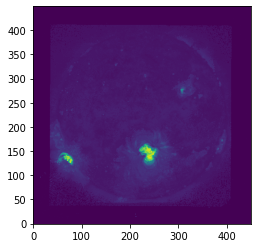

In [33]:
plt.imshow(em.sum(axis=0),origin='lower',norm=ImageNormalize(vmin=1e15,vmax=5e27,stretch=LogStretch()))

In [18]:
dem['dem'].wcs

CompoundLowLevelWCS Transformation

This transformation has 3 pixel and 3 world dimensions

Array shape (Numpy order): None

Pixel Dim  Axis Name  Data size  Bounds
        0  None            None  None
        1  None            None  None
        2  None            None  None

World Dim  Axis Name    Physical Type                   Units
        0  None         custom:pos.helioprojective.lon  deg
        1  None         custom:pos.helioprojective.lat  deg
        2  temperature  phys.temperature                K

Correlation between pixel and world axes:

             Pixel Dim
World Dim    0    1    2
        0  yes  yes   no
        1  yes  yes   no
        2   no   no  yes